In [2]:
# https://exupery-1.tistory.com/206

In [1]:
import numpy as np
import pylab as pl

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 

from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GridSearchCV  

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf

from numpy.random import seed # 예측 결과 일정하게 하기 위함
seed(1) # 예측 결과 일정하게 하기 위함
tf.random.set_seed(2) # 예측 결과 일정하게 하기 위함

from bayes_opt import BayesianOptimization #바예시안 opt for 하이퍼파라미터 튜닝 
from keras import optimizers 
from keras.callbacks import EarlyStopping

In [2]:
#모든 gpu 할당

import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [3]:
data = pd.read_csv("bladder_cancer.csv")
data.head(3)

,Amp_1MHz,Phase_1MHz,Amp_500kHz,Phase_500kHz,Amp_100kHz,Phase_100kHz,Amp_50kHz,Phase_50kHz,Amp_10kHz,Phase_10kHz,Label
0,1826.379159,-83.458529,3578.605538,-85.824932,17848.77353,-85.555033,30923.77481,-84.679487,121151.8394,-79.349716,1
1,1822.430390,-83.707765,3588.429488,-85.421176,17537.29920,-87.164969,31855.09213,-88.802440,121616.4272,-78.980499,1
2,1824.105505,-83.823186,3532.988697,-85.372390,16429.97769,-87.916345,31066.25861,-83.519898,121313.6036,-79.646773,1


In [4]:
# pd.set_option('display.max_rows',None) # pandas 의 row 값을 모두 보고 싶을 때 설정하는 option
data.isnull().sum()

Amp_1MHz        0
Phase_1MHz      0
Amp_500kHz      0
Phase_500kHz    0
Amp_100kHz      0
Phase_100kHz    0
Amp_50kHz       0
Phase_50kHz     0
Amp_10kHz       0
Phase_10kHz     0
Label           0
dtype: int64

In [5]:
data = data.dropna()

In [6]:
data.isnull().sum()

Amp_1MHz        0
Phase_1MHz      0
Amp_500kHz      0
Phase_500kHz    0
Amp_100kHz      0
Phase_100kHz    0
Amp_50kHz       0
Phase_50kHz     0
Amp_10kHz       0
Phase_10kHz     0
Label           0
dtype: int64

In [7]:
data[0:1]

,Amp_1MHz,Phase_1MHz,Amp_500kHz,Phase_500kHz,Amp_100kHz,Phase_100kHz,Amp_50kHz,Phase_50kHz,Amp_10kHz,Phase_10kHz,Label
0,1826.379159,-83.458529,3578.605538,-85.824932,17848.77353,-85.555033,30923.77481,-84.679487,121151.8394,-79.349716,1


In [8]:

X = data.drop(columns=['Label'], axis=1)
y = data['Label']

In [9]:
# train_set with cross-validation : test_set = 80 : 20 
train_feature, test_feature, train_label, test_label = train_test_split(X, y, test_size = 0.2,random_state=0)

In [10]:
print(train_feature.shape)
print(test_feature.shape)
print(train_label.shape)
print(test_label.shape)

(188, 10)
(48, 10)
(188,)
(48,)


In [11]:
# feature normalization, label 은 normalization 진행하지 않았음
scaler = StandardScaler() # scaler 객체 생성
scaler.fit(train_feature) # train_feature 의 mean 과 standard deviation 값을 추출
train_feature_scaled = scaler.transform(train_feature) # train_feature 의 정규화 진행
test_feature_scaled = scaler.transform(test_feature) # test_feature 의 정규화 진행.
# test_feature 는 mean 과 standard deviation 값을 추출하는 과정 하면 안됨. 
# 학습할 때와 동일한 기반 설정으로 동일하게 테스트 데이터를 변환되야 함. 

In [12]:
# pandas numpy 로 변환
train_label = np.array(train_label)
test_label = np.array(test_label)

In [13]:
################################################################################################################
# 옵티마이저 추가

SGD = tf.keras.optimizers.SGD
Adam = tf.keras.optimizers.Adam
RMSprop = tf.keras.optimizers.RMSprop
Adadelta=tf.keras.optimizers.Adadelta
Adagrad=tf.keras.optimizers.Adagrad
Nadam=tf.keras.optimizers.Nadam
Ftrl=tf.keras.optimizers.Ftrl
Adamax = tf.keras.optimizers.Adamax

# activation fuction LeakyReLU 추가 & warning 무시

from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

# keras, sklearn 모듈

from keras.wrappers.scikit_learn import KerasClassifier 
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

score_acc = make_scorer(accuracy_score)



In [14]:


def nn_cl_bo2(neurons, activation, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, layers3, normalization, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    layers3 = round(layers3)
    def nn_cl_fun():
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=10, activation=activation))
        if normalization > 0.5:
            nn.add(BatchNormalization())
        for i in range(layers1):
            nn.add(Dense(neurons, activation=activation))
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=123))
        for i in range(layers2):
            nn.add(Dense(neurons, activation=activation))
        for i in range(layers3):
            nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size, verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(nn, train_feature_scaled,train_label, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [16]:
from bayes_opt import BayesianOptimization #바예시안 opt for 하이퍼파라미터 튜닝 

params_nn2 ={
    'neurons': (10, 100),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.0001, 0.0002),
    'batch_size':(100, 110),
    'epochs':(20,100),
    'layers1':(20,30),
    'layers2':(150,250),
    'layers3':(150,250),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo2, params_nn2, random_state=42)
nn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  |  layers3  | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
2/2 [==============================] - 2s 22ms/step
|  1        |  0.5532   |  3.371    |  109.5    |  0.732    |  0.1796   |  32.48    |  21.56    |  155.8    |  236.6    |  0.000160 |  73.73    |  0.02058  |  6.789    |
2/2 [==============================] - 2s 19ms/step
|  2        |  0.5532   |  7.492    |  102.1    |  0.1818   |  0.05502  |  44.34    |  25.25    |  193.2    |  179.1    |  0.000161 |  22.55    |  0.2921   |  2.565    |
2/2 [==============================] - 2s 34ms/step
|  3        |  0.6922   |  4.105    |  107.9    |  0.1997   |  0.1543   |  67.39    |  20.46    |  210.8    |  167.1    |  0.000106 |  95.4     |  0.9656   |  5.659

KeyboardInterrupt: 

In [ ]:
params_nn_ = nn_bo.max['params']
learning_rate = params_nn_['learning_rate']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_['batch_size'] = round(params_nn_['batch_size'])
params_nn_['epochs'] = round(params_nn_['epochs'])
params_nn_['layers1'] = round(params_nn_['layers1'])
params_nn_['layers2'] = round(params_nn_['layers2'])
params_nn_['layers3'] = round(params_nn_['layers3'])
params_nn_['neurons'] = round(params_nn_['neurons'])
optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','Adam']
optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
             'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
             'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
             'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
params_nn_['optimizer'] = optimizerD[optimizerL[round(params_nn_['optimizer'])]]
params_nn_

{'activation': <keras.layers.activation.leaky_relu.LeakyReLU at 0x20d6d7dab20>,
 'batch_size': 20,
 'dropout': 0.21719842047461124,
 'dropout_rate': 0.11024613619893728,
 'epochs': 42,
 'layers1': 2,
 'layers2': 1,
 'layers3': 3,
 'learning_rate': 0.5164941332156879,
 'neurons': 12,
 'normalization': 0.768859349093111,
 'optimizer': <keras.optimizers.optimizer_v2.adagrad.Adagrad at 0x20dba4c1340>}

In [ ]:
def nn_cl_fun():

    nn = Sequential()
    nn.add(Dense(params_nn_['neurons'], input_dim=10, activation=params_nn_['activation']))
    if params_nn_['normalization'] > 0.5:
            nn.add(BatchNormalization())
    for i in range(params_nn_['layers1']):
            nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
    if params_nn_['dropout'] > 0.5:
            nn.add(Dropout(params_nn_['dropout_rate'], seed=123))
    for i in range(params_nn_['layers2']):
            nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
    for i in range(params_nn_['layers3']):
            nn.add(Dense(params_nn_['neurons'], activation=params_nn_['activation']))
    nn.add(Dense(1, activation='sigmoid'))
    nn.compile(loss='binary_crossentropy', optimizer=params_nn_['optimizer'], metrics=['accuracy'])
    return nn
    
es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
nn = KerasClassifier(build_fn=nn_cl_fun, epochs=params_nn_['epochs'], batch_size=params_nn_['batch_size'],
                         verbose=0)

## k-fold 추가
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, validation_index in skf.split(train_feature_scaled,train_label):
        nn.fit(train_feature_scaled,train_label, validation_data=(train_feature_scaled[validation_index],train_label[validation_index]), verbose=1)

Epoch 1/42
10/10 [==============================] - 1s 25ms/step - loss: 0.7567 - accuracy: 0.5266 - val_loss: 0.6741 - val_accuracy: 0.7105
Epoch 2/42
10/10 [==============================] - 0s 12ms/step - loss: 0.6217 - accuracy: 0.6862 - val_loss: 0.7955 - val_accuracy: 0.7368
Epoch 3/42
10/10 [==============================] - 0s 12ms/step - loss: 0.4319 - accuracy: 0.8032 - val_loss: 0.7266 - val_accuracy: 0.6053
Epoch 4/42
10/10 [==============================] - 0s 9ms/step - loss: 0.6360 - accuracy: 0.6702 - val_loss: 0.5355 - val_accuracy: 0.7105
Epoch 5/42
10/10 [==============================] - 0s 10ms/step - loss: 0.5916 - accuracy: 0.7128 - val_loss: 0.7398 - val_accuracy: 0.7895
Epoch 6/42
10/10 [==============================] - 0s 9ms/step - loss: 0.6239 - accuracy: 0.7128 - val_loss: 0.4706 - val_accuracy: 0.8158
Epoch 7/42
10/10 [==============================] - 0s 8ms/step - loss: 0.5687 - accuracy: 0.7340 - val_loss: 0.5073 - val_accuracy: 0.7632
Epoch 8/42
10/10

In [ ]:
nn.score(train_feature_scaled,train_label), nn.score(train_feature_scaled[validation_index],train_label[validation_index]), nn.score(test_feature_scaled, test_label)

(0.9627659320831299, 1.0, 0.8958333134651184)

In [ ]:
# k-Fold Cross Validation
from sklearn.model_selection import StratifiedKFold

n_fold=5
skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

accuracy=[]

for train_index, validation_index in skf.split(train_feature_scaled,train_label):
  model = tf.keras.models.Sequential([tf.keras.layers.Dense(20, input_dim=10, activation='relu'),
                                      tf.keras.layers.Dense(140, activation='relu'),
                                      tf.keras.layers.Dense(140, activation='relu'),
                                      tf.keras.layers.Dense(140, activation='relu'),
                                      tf.keras.layers.Dense(1, activation='sigmoid')
                                      ])

  optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=['accuracy'])
  
  history = model.fit(train_feature_scaled[train_index], train_label[train_index]
                      ,validation_data=(train_feature_scaled[validation_index],train_label[validation_index])
                      ,epochs=500
                      ,batch_size=100
                      ,callbacks=EarlyStopping(monitor='val_loss',patience=10)
                      )
  # callbacks=EarlyStopping(monitor='loss',patience=10)
  
  accuracy_history = history.history['accuracy'] # training data accuracy
  val_accuracy_history = history.history['val_accuracy'] # validation data accuracy
  loss_history = history.history['loss'] # training data loss
  val_loss_history = history.history['val_loss'] # training data loss


  k_accuracy = f"{model.evaluate(train_feature_scaled[validation_index],train_label[validation_index])[1]:.4f}"
  accuracy.append([k_accuracy,accuracy_history,val_accuracy_history, loss_history, val_loss_history])


Epoch 1/500
2/2 [==============================] - 0s 138ms/step - loss: 0.7083 - accuracy: 0.4600 - val_loss: 0.6831 - val_accuracy: 0.4474
Epoch 2/500
2/2 [==============================] - 0s 29ms/step - loss: 0.7019 - accuracy: 0.4600 - val_loss: 0.6800 - val_accuracy: 0.4737
Epoch 3/500
2/2 [==============================] - 0s 44ms/step - loss: 0.6962 - accuracy: 0.4667 - val_loss: 0.6770 - val_accuracy: 0.5000
Epoch 4/500
2/2 [==============================] - 0s 37ms/step - loss: 0.6908 - accuracy: 0.4867 - val_loss: 0.6741 - val_accuracy: 0.5000
Epoch 5/500
2/2 [==============================] - 0s 45ms/step - loss: 0.6852 - accuracy: 0.5133 - val_loss: 0.6714 - val_accuracy: 0.5263
Epoch 6/500
2/2 [==============================] - 0s 26ms/step - loss: 0.6801 - accuracy: 0.5533 - val_loss: 0.6687 - val_accuracy: 0.5526
Epoch 7/500
2/2 [==============================] - 0s 23ms/step - loss: 0.6752 - accuracy: 0.5733 - val_loss: 0.6662 - val_accuracy: 0.6053
Epoch 8/500
2/2 [==

In [ ]:


model.evaluate(test_feature_scaled, test_label)
model.evaluate(train_feature_scaled,train_label)
model.evaluate(train_feature_scaled[validation_index],train_label[validation_index])
model.evaluate(test_feature_scaled, test_label)

# epoch 를 200 까지 늘리니 loss 값이 좀 늘어남. accuracy 는 그대로 0.9375 

2/2 [==============================] - 0s 3ms/step - loss: 0.2583 - accuracy: 0.9375


[0.2583320736885071, 0.9375]

In [ ]:
# print(accuracy_history)

In [ ]:
# print(val_accuracy_history)

In [ ]:
print(k_accuracy)

0.8919


In [ ]:
# accuracy

Text(0.5, 1.0, 'Prediction accuracy using validation dataset with respect to epochs at each fold')

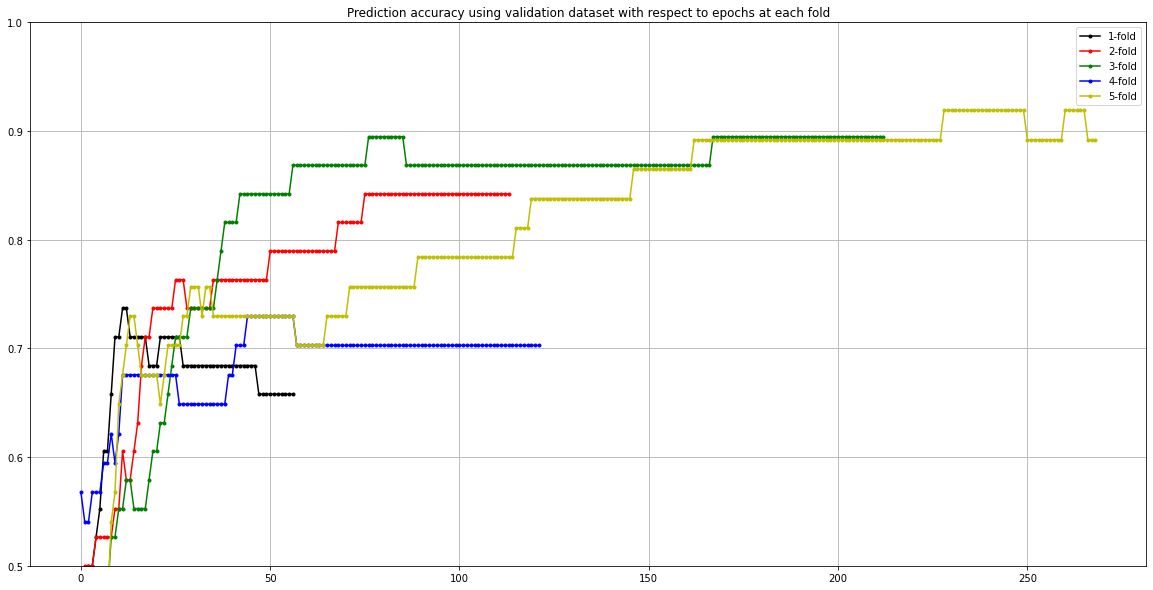

In [ ]:
## Visualize history
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
colours = 'krgby'
for i in range(n_fold):
  # plt.plot(accuracy[i][1],marker='.',c=colours[i],label=str(i+1)+"-fold")
  plt.plot(accuracy[i][2],marker='.',c=colours[i], label=str(i+1)+"-fold") # 각각의 fold 마다 accuracy 출력
plt.ylim(0.5,1.0)
plt.grid()
plt.legend()
plt.title('Prediction accuracy using validation dataset with respect to epochs at each fold')

Text(0.5, 1.0, 'Loss using train dataset with respect to epochs at each fold')

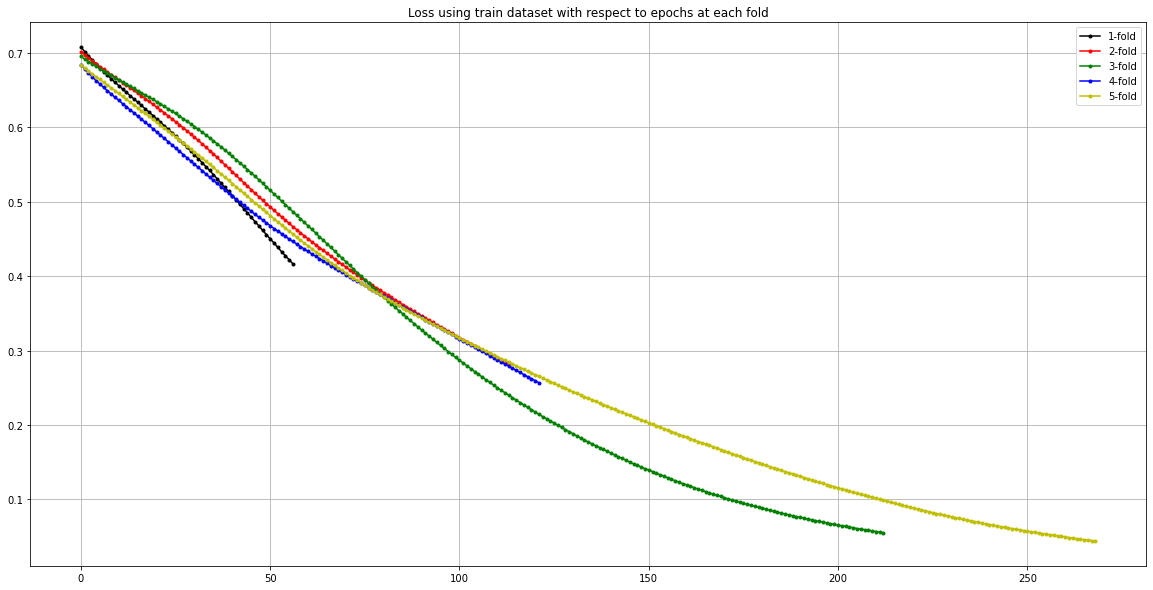

In [ ]:
## Visualize history
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
colours = 'krgby'
for i in range(n_fold):
  # plt.plot(accuracy[i][1],marker='.',c=colours[i],label=str(i+1)+"-fold")
  plt.plot(accuracy[i][3],marker='.',c=colours[i], label=str(i+1)+"-fold") # 각각의 fold 마다 accuracy 출력
#plt.ylim(0,1.0)
plt.grid()
plt.legend()
plt.title('Loss using train dataset with respect to epochs at each fold')

Text(0.5, 1.0, 'Loss using validation dataset with respect to epochs at each fold')

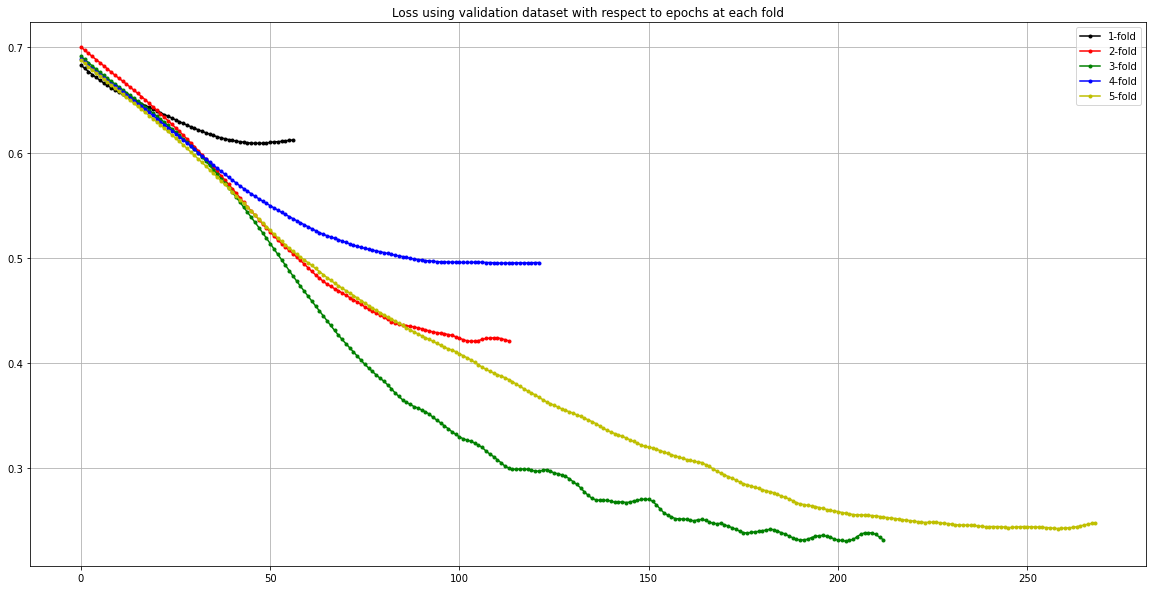

In [ ]:
## Visualize history
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
colours = 'krgby'
for i in range(n_fold):
  # plt.plot(accuracy[i][1],marker='.',c=colours[i],label=str(i+1)+"-fold")
  plt.plot(accuracy[i][4],marker='.',c=colours[i], label=str(i+1)+"-fold") # 각각의 fold 마다 accuracy 출력
#plt.ylim(0,1.0)
plt.grid()
plt.legend()
plt.title('Loss using validation dataset with respect to epochs at each fold')

In [ ]:
print(accuracy[0][2])
print(np.array(accuracy[0][2]))

[0.44736841320991516, 0.4736842215061188, 0.5, 0.5, 0.5263158082962036, 0.5526315569877625, 0.6052631735801697, 0.6052631735801697, 0.6578947305679321, 0.7105262875556946, 0.7105262875556946, 0.7368420958518982, 0.7368420958518982, 0.7105262875556946, 0.7105262875556946, 0.7105262875556946, 0.7105262875556946, 0.7105262875556946, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.7105262875556946, 0.7105262875556946, 0.7105262875556946, 0.7105262875556946, 0.7105262875556946, 0.7105262875556946, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6842105388641357, 0.6578947305679321, 0.6578947305679321, 0.6578947305679321, 0.6578947305679321, 0.657894

In [ ]:
# averaging validation accuracy

In [ ]:
validation_accuracy_sum = 0
validation_accuracy_mean = 0

for i in range(n_fold):
    validation_accuracy_sum = validation_accuracy_sum + np.array(accuracy[i][2]) 
    
validation_accuracy_mean = validation_accuracy_sum/n_fold
    
print(validation_accuracy_mean)

ValueError: operands could not be broadcast together with shapes (57,) (114,) 

Text(0.5, 1.0, 'Everage prediction accuracy using validation dataset with respect to epochs at each fold')

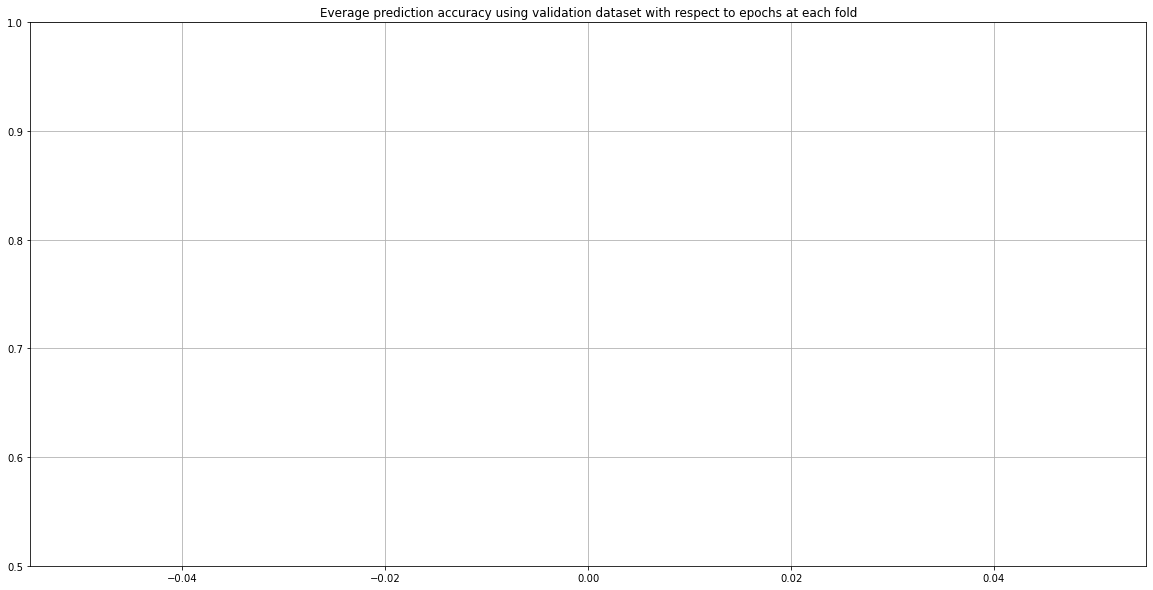

In [ ]:
## Visualize history
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
colours = 'krgby'
for i in range(n_fold):
  # plt.plot(accuracy[i][1],marker='.',c=colours[i],label=str(i+1)+"-fold")
  plt.plot(validation_accuracy_mean, marker='.') # 각각의 fold 마다 accuracy 출력
plt.ylim(0.5,1.0)
plt.grid()
# plt.legend()
plt.title('Everage prediction accuracy using validation dataset with respect to epochs at each fold')

In [ ]:
# averaging validation loss

In [ ]:
validation_loss_sum = 0
validation_loss_mean = 0

for i in range(n_fold):
    validation_loss_sum = validation_loss_sum + np.array(accuracy[i][4]) 
    
validation_loss_mean = validation_loss_sum/n_fold
    
print(validation_loss_mean)

ValueError: operands could not be broadcast together with shapes (57,) (114,) 

Text(0.5, 1.0, 'Everage prediction loss using validation dataset with respect to epochs at each fold')

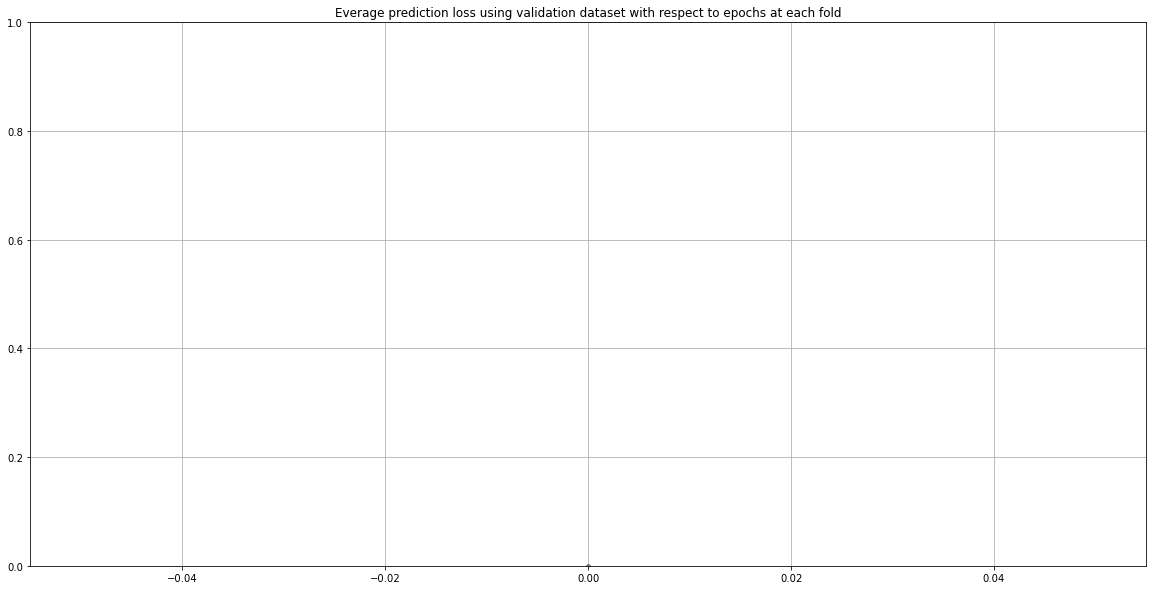

In [ ]:
## Visualize history
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
colours = 'krgby'
for i in range(n_fold):
  # plt.plot(accuracy[i][1],marker='.',c=colours[i],label=str(i+1)+"-fold")
  plt.plot(validation_loss_mean, marker='.') # 각각의 fold 마다 accuracy 출력
plt.ylim(0,1.0)
plt.grid()
# plt.legend()
plt.title('Everage prediction loss using validation dataset with respect to epochs at each fold')

In [ ]:
np.argmin(validation_loss_mean)

0